# Discharge Capacity Model for Lithium-Ion Battery Cells

## Problem statement

This project aims to create a model of discharge capacity change with respect to the number of discharge cycles of a lion battery cell.

## Use cases

1. Predictive maintainance of battery cells, which can lead to the decrease of potentially dangerous battery-related incidents.
2. Better estimation of battery cell discharge capacity.
3. EV range estimation.

## Data source

Data used for this project comes from the NASA Battery Dataset provided on [Kaggle](https://www.kaggle.com/datasets/patrickfleith/nasa-battery-dataset). The Kaggle repository contains an already preprocessed version of the original NASA dataset, which we then process for our own purpose.

## DAG

![soh_data.drawio.png](soh_data.drawio.png)

## "Confoundings" in the model

Since the data we used is essentialy taken for the same type of battery, during the same process, we needn't worry about any confounding variables in this case.

----

## Data Preprocessing & Extraction
For project purpouses we decided to use only data for the specific batteries with ID due to the common expriements background:
- B0005
- B0006
- B0007

Description of the expirements for those batteries can be found in [README_05_06_07_18](./cleaned_dataset/extra_infos/README_05_06_07_18.txt) file.

### Part of the README_05_06_07_18.txt file
```
Data Description:
A set of four Li-ion batteries (# 5, 6, 7 and 18) were run through 3 different operational profiles 
(charge, discharge and impedance) at room temperature. Charging was carried out in a constant current (CC) 
mode at 1.5A until the battery voltage reached 4.2V and then continued in a constant voltage (CV) mode 
until the charge current dropped to 20mA. Discharge was carried out at a constant current (CC) level of 2A 
until the battery voltage fell to 2.7V, 2.5V, 2.2V and 2.5V for batteries 5 6 7 and 18 respectively. 
Impedance measurement was carried out through an electrochemical impedance spectroscopy (EIS) frequency sweep 
from 0.1Hz to 5kHz. Repeated charge and discharge cycles result in accelerated aging of the batteries while 
impedance measurements provide insight into the internal battery parameters that change as aging progresses. 
The experiments were stopped when the batteries reached end-of-life (EOL) criteria, which was a 30% fade 
in rated capacity (from 2Ahr to 1.4Ahr). This dataset can be used for the prediction of both remaining charge 
(for a given discharge cycle) and remaining useful life (RUL).
```

Those data were exported from the original dataset that can be found in [cleaned_dataset](./cleaned_dataset) directory to the `picked_data` dictionary by the below python code block.

In [12]:
import pandas as pd
import csv
from tqdm import tqdm

# Picked data
picked_data = {
    'battery_id': ['B0005', 'B0006', 'B0007'],
    'cycle_type': ['discharge']
}

metadata_path = 'cleaned_dataset/metadata.csv'
data = {}

# Read metadata.csv and creating data dictionary
with open(metadata_path, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        battery_id = row['battery_id']
        if battery_id in picked_data['battery_id']:
            data[battery_id] = {
                'charge': {},
                'discharge': {},
                'impedance': {}
            }

data_path = 'cleaned_dataset/data/'

cycle_ids = {
    'charge': 0,
    'discharge': 0,
    'impedance': 0
}

# Read and store metadata information for analyzed batteries
metadata = pd.read_csv('cleaned_dataset/metadata.csv')

# Create a progress bar
pbar = tqdm(total=len(metadata))

# Iterate over each row in the metadata dataframe
for index, row in metadata.iterrows():
    if index == 0:
        metadata_headers = row.keys()

    if row['battery_id'] != battery_id:
        cycle_ids = {
            'charge': 0,
            'discharge': 0,
            'impedance': 0
        }
    cycle_type = row['type']
    cycle_id = cycle_ids[cycle_type]
    battery_id = row['battery_id']

    if cycle_type in picked_data['cycle_type'] and battery_id in picked_data['battery_id']:
        values_metadata = {}
        # To values append non-empty values of metadata headers
        for header in metadata_headers:
            if row[header] != '':
                values_metadata[header] = row[header]

        filename = row['filename']

        with open(data_path+filename, 'r') as csvfile:
            csvreader = csv.DictReader(csvfile)
            headers = csvreader.fieldnames
            values = {header: [] for header in headers}
            for row in csvreader:
                for header in headers:
                    values[header].append(row[header])
            
            # Concatenate metadata and data values
            values = {**values_metadata, **values}
            data[battery_id][cycle_type][cycle_id] = values
            csvfile.close()
        cycle_ids[cycle_type] += 1

    # Update the progress bar
    pbar.update(1)

# Close the progress bar
pbar.close()


  0%|          | 0/7565 [00:00<?, ?it/s]

100%|██████████| 7565/7565 [00:00<00:00, 16307.25it/s]


## Data preprocessing

The extraction of features is done in a common way for all datasets for all batteries.

### Feature extraction

`start_voltage` - For each discharge cycle, we take the initial (start) voltage value. Expressed in volts [V].

`stop_voltage` - For each discharge cycle, we take the final (end) voltage value. This value is taken at the point where the load current changes from -2A to ~0A. Expressed in volts [V].

`current_ptp` - The total time the constant load was applied. Expressed in seconds [s].

To simplify the code here, we've put the feature extraction code in a separate Python file: `feature_extraction/features.py`

In [13]:
from feature_extraction import features
import numpy as np

# function array string to array float
def array_str_to_float(array_str):
    array_float = []
    for i in range(len(array_str)):
        array_float.append(float(array_str[i]))
    return array_float

# add features to data dictionary
for battery_id in data.keys():
    for cycle_type in data[battery_id].keys():
        for cycle_id in data[battery_id][cycle_type].keys():
            if cycle_type == 'discharge':
                data[battery_id][cycle_type][cycle_id]['start_voltage'] = features.get_start_voltage(
                    pd.Index(array_str_to_float(data[battery_id][cycle_type][cycle_id]['Voltage_measured'])))
                data[battery_id][cycle_type][cycle_id]['stop_voltage'] = features.get_stop_voltage(
                    pd.Index(array_str_to_float(data[battery_id][cycle_type][cycle_id]['Voltage_measured'])))
                data[battery_id][cycle_type][cycle_id]['current_ptp'] = features.get_current_ptp(
                    pd.Index(array_str_to_float(data[battery_id][cycle_type][cycle_id]['Current_measured'])),
                    pd.Index(array_str_to_float(data[battery_id][cycle_type][cycle_id]['Time'])))

Since we'll be trying to fit the discharge capacity over multiple cycles for different batteries, the data is organized into a dictionary as visible above.

### Visualization of analyzed data

Below we visualize how these parameters change over the number of discharge cycles:
- Discharge time.
- Capacity.
- SoH.


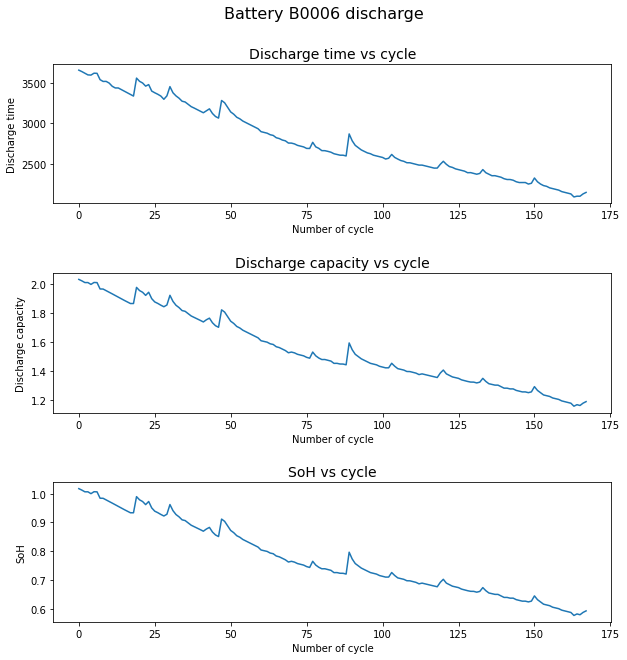

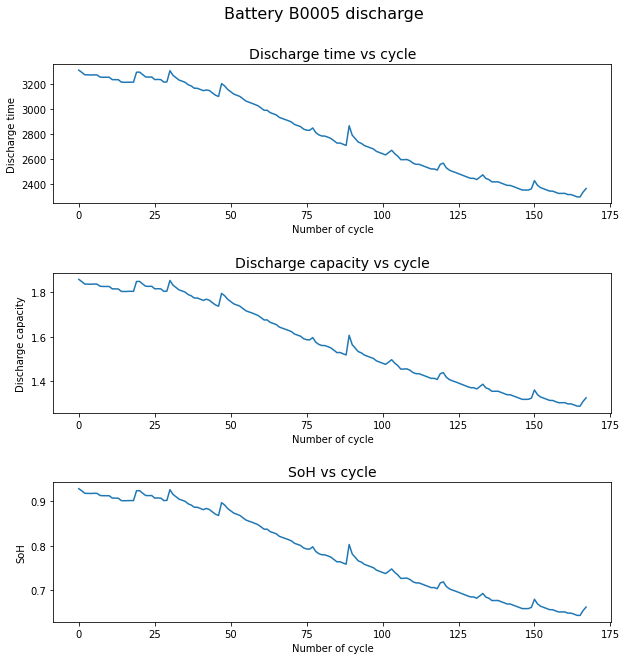

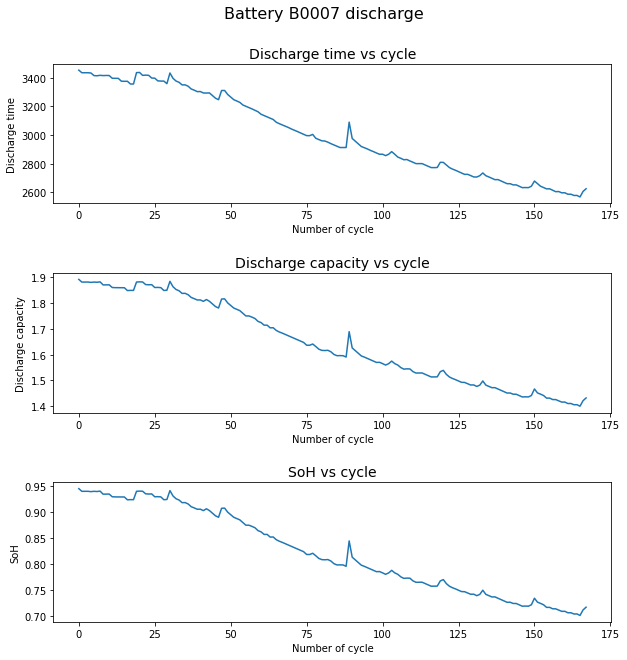

In [14]:
import matplotlib.pyplot as plt

rated_capacity = 2.0 # taken from metadata
# plot discharge time vs cycle
for battery_id in data.keys():
    for cycle_type in data[battery_id].keys():
        if cycle_type == 'discharge':
            cycles = list(data[battery_id][cycle_type].keys())
            discharge_capacities = [float(data[battery_id][cycle_type][cycle_id]['Capacity']) for cycle_id in cycles]
            soh_values = [discharge_capacities[i] / rated_capacity for i in range(len(discharge_capacities))]
            # concatenate each current_ptp for specific battery into one array
            discharge_times = [data[battery_id][cycle_type][cycle_id]['current_ptp'] for cycle_id in cycles]

            # create a figure with 3 subplot
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
            fig.suptitle('Battery ' + battery_id + ' discharge', fontsize=16)
            fig.subplots_adjust(top=0.9, hspace=0.5)
            # plot cycles vs discharge time
            ax1.plot(cycles, discharge_times)
            ax1.set_xlabel('Number of cycle')
            ax1.set_ylabel('Discharge time')
            ax1.set_title('Discharge time vs cycle')
            ax1.title.set_size(14)

            # plot cycles vs discharge capacity
            ax2.plot(cycles, discharge_capacities)
            ax2.set_xlabel('Number of cycle')
            ax2.set_ylabel('Discharge capacity')
            ax2.set_title('Discharge capacity vs cycle')
            ax2.title.set_size(14)

            # plot cycles vs soh
            ax3.plot(cycles, soh_values)
            ax3.set_xlabel('Number of cycle')
            ax3.set_ylabel('SoH')
            ax3.set_title('SoH vs cycle', )
            ax3.title.set_size(14)
            plt.show()
            fig.savefig('plots/battery_' + battery_id + '_discharge.png')

TODO: napl: add explanation of the plots

## Models

In [15]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az
import statsmodels.api as sm
import numpy as np

In [16]:
from scipy.interpolate import BSpline
import warnings
LIGHT="#FFFCDC"
LIGHT_HIGHLIGHT="#FEF590"
MID="#FDED2A"
MID_HIGHLIGHT="#F0DC05"
DARK="#EECA02"
DARK_HIGHLIGHT="#BB9700"
GREEN="#00FF00"
LIGHT_GREY="#DDDDDD"

# Below implementations is accesed from: 
# repo: https://github.com/KAIR-ISZ/public_data/blob/master/cables/depth_analysis.ipynb
# author: Jerzy Baranowski
def is_sorted(a):
    '''
    Check if numpy 1d-array is sorted
    '''
    if type(a) != np.ndarray:
        raise TypeError('Argument must be a numpy array but is {}'.format(type(a)))
    if len(a.shape) > 1:
        raise ValueError('Array must be 1 dimensional but has shape {}'.format(a.shape))
    return np.all(a[:-1] <= a[1:])

def sort_1d_array_and_2d_array_by_1d_array(x, fx):
    if (type(x) != np.ndarray) or (type(fx) != np.ndarray):
        raise TypeError('At least one of the arguments is not a numpy array type(x)={}, type(fx)={}',format(type(x),type(fx)))
    if len(x)!=fx.shape[1]:
        raise ValueError('2d array number of columns is not matching the 1d array. Expected {} got {}'.format(len(x),fx.shape[1]))
    arr2D = np.concatenate([np.expand_dims(x,axis=0),fx],axis=0)
    sortedArr = arr2D [ :, arr2D[0].argsort()]
    return sortedArr[0,:], sortedArr[1:,:]

def get_quantiles(fx, probs=None):
    if probs is None:
        probs = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    if len(probs) % 2 == 0:
        raise ValueError('Number of quantiles must be even')
    if len(probs) > 11:
        raise ValueError('Too many quantiles (max is 11)')
    if probs[int(len(probs)/2)] != 50:
        raise ValueError('Middle quantile should be 50 but is {}'.format(probs(int(len(probs)/2))))
    return np.percentile(fx, probs, axis=0)


def ribbon_plot(x, fx, ax=None,zorder=0,probs=None,supress_warning=False):
    '''
    Plot a ribbon plot for regression and similar.
    Plot consists of quantiles (by 10%) of a variate (fx) as a function of covariate (x).
    x has shape (n, )
    fx has shape (N,n)
    '''
    if ax is None:
        ax = plt.gca()
    if not is_sorted(x):
        x, fx = sort_1d_array_and_2d_array_by_1d_array(x, fx)
    if (len(set(x)) != len(x)) and (not supress_warning):
        warnings.warn("x variable has repeated values, which can influence the plot")    
    perc_interv = get_quantiles(fx, probs)
    nq=perc_interv.shape[0]
    colortab = [LIGHT,LIGHT_HIGHLIGHT,MID,MID_HIGHLIGHT,DARK,DARK_HIGHLIGHT]

    for i in range(int(nq/2)):
        ax.fill_between(x,
                        perc_interv[i,:],
                        perc_interv[-(i+1),:],
                        color=colortab[i],
                        zorder=zorder)
    ax.plot(x,perc_interv[int(nq/2),:],color=colortab[int(nq/2)],zorder=zorder)
    return ax
def create_spline_matrix(N,T,time,spl_order=3,num_knots=7):
    '''
    N - Number of time series,
    T - number of samples
    time - array/series of time values
    '''
    time=np.array(time) 
    knot_list = np.quantile(time, np.linspace(0, 1, num_knots))
    knots = np.pad(knot_list, (spl_order, spl_order), mode="edge")
    B = BSpline(knots, np.identity(num_knots + 2),
                k=spl_order)(time[0:T])
    # Design matrix
    return np.tile(B, (N, 1))


To create a spline model it is required to establish number of time series and number of samples.
In case of analyzed data those parameters can be defined as:
- number of time series is equal to 3 since discharging cycles for 3 different batteries are being analyzed,
- number of samples is equal to number of discharging cycles in each battery (this number must be the same for each battery).

In [17]:
# Print number of cycles for each battery
for battery_id in data.keys():
    for cycle_type in data[battery_id].keys():
        if cycle_type == 'discharge':
            print('Battery ' + battery_id + ' has ' + str(len(data[battery_id][cycle_type])) + ' cycles')

Battery B0006 has 168 cycles
Battery B0005 has 168 cycles
Battery B0007 has 168 cycles


In [18]:
# N - number of batteries
N = 3
# M - number of discharging cycles in each battery (must be the same for all batteries)
M = 168

# time - list of number of cycles
time = [int(cycle) for cycle in data['B0005']['discharge'].keys()]

# spline order = 3 means cubic spline
spline_order = 3
knots_number = 10
knots_list = np.quantile(time, np.linspace(0, 1, knots_number))

In [19]:
# create a pd dataframe with discharge capacity data and cycle number for each battery witch each cycle in separate row
df_discharge = pd.DataFrame(
    columns=['battery_id', 'cycle_id', 'capacity'])
for battery_id in data.keys():
    for cycle_type in data[battery_id].keys():
        if cycle_type == 'discharge':
            for cycle_id in data[battery_id][cycle_type].keys():
                # use pandas concat function to add new row to dataframe
                df_discharge = pd.concat([df_discharge, pd.DataFrame({'battery_id': [battery_id],
                                                                      'cycle_id': np.array(cycle_id, dtype=int), 
                                                                      'capacity': np.array(data[battery_id][cycle_type][cycle_id]['Capacity'], dtype=float)})], 
                                                                      ignore_index=True)

### How model should work like?

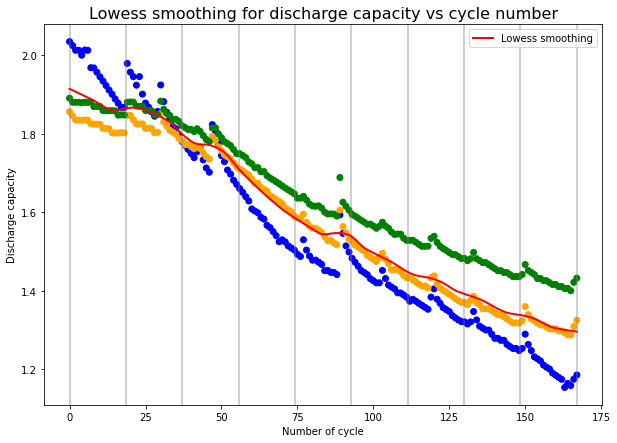

In [20]:
colors_battery = {'B0005': "orange", 'B0006': "blue", 'B0007': "green"}
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(df_discharge['cycle_id'], df_discharge['capacity'], c=df_discharge['battery_id'].apply(lambda x: colors_battery[x]))
ax.set_xlabel('Number of cycle')
ax.set_ylabel('Discharge capacity')
for knot in knots_list:
    ax.axvline(x=knot, color='grey', alpha=0.5)

lowess = sm.nonparametric.lowess
lowess_data = lowess(df_discharge['capacity'], df_discharge['cycle_id'], frac=0.1)
ax.plot(lowess_data[:, 0], lowess_data[:, 1], color='red', linewidth=2, label='Lowess smoothing')

ax.legend()
ax.set_title('Lowess smoothing for discharge capacity vs cycle number', fontsize=16)
fig.savefig('plots/lowess_smoothing_discharge_capacity.png')


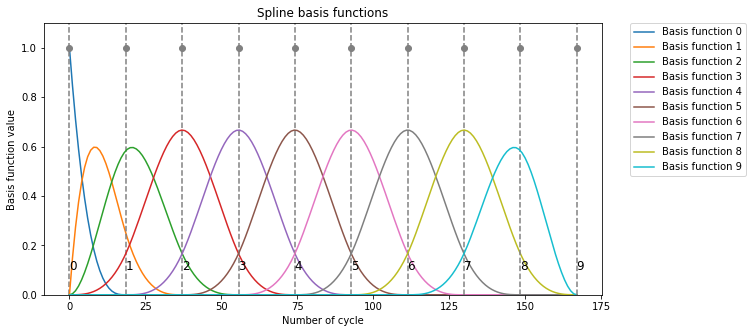

In [21]:
# Create spline matrix
B = create_spline_matrix(N, M, time, spline_order, knots_number)
B0 = B[0:M, :]

# Plot spline base
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(knots_number+2):
    if i < knots_number:
        ax.plot(time, B0[:, i], label='Basis function ' + str(i))
        ax.axvline(knots_list[i], color='gray', linestyle='--')
        ax.text(s=str(i), x=knots_list[i], y=0.1, fontsize=12)
        ax.scatter(knots_list[i], 1, marker='o', color='gray', zorder=3)
ax.set_xlabel('Number of cycle')
ax.set_ylabel('Basis function value')
ax.set_ylim(0, 1.1)
ax.set_title('Spline basis functions')
# show legend on the right to the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
fig.savefig('plots/spline_basis_functions.png')

## Model 1 - Bayesian Linear Regression

### Model description
This model draws inspiration from the research presented in ["Recognizing VSC DC Cable Fault Types Using Bayesian Functional Data Depth"](https://www.mdpi.com/1996-1073/14/18/5893) paper by authors: Jerzy Baranowski, Katarzyna Grobler-Dębska, and Edyta Kucharska. 

Although the model presented in the paper uses QR decomposition to fit the Bayesian linear regression model with a spline prior on the coefficients, in our project a centered parameterization instead of QR decomposition is used. This approach was chosen because centered parameterization has the advantage of being simpler to implement and can often be more efficient in computation compared to the QR decomposition approach.

The model is a Bayesian linear regression model with a spline prior on the coefficients. Model performs regression of the dataset of $N$ observations with $K$ predictors. The uncentered coefficients $\boldsymbol{\beta}_{\text{raw}}$ are transformed to centered coefficients $\boldsymbol{\beta}$ by applying the spline prior mean $\mu_0$ and standard deviation $\sigma_0$. The model predicts outcomes $\mathbf{y}$ using the centered coefficients and generates predicted values $\mathbf{y}_{\text{pred}}$ by sampling from the normal distribution with mean $\mathbf{\mu}$ and standard deviation $\sigma$.

1. Data:
    - $N$ - Number of data points (observations).
    - $K$ - Number of predictors (features).
    - $L$ - Number of simulated samples (used for generating predicted values).
    - $\mathbf{x}$ - Predictor matrix (dimensions $N \times K$).
    - $\mathbf{y}$ - Output vector (length $N$).

2. Parameters:
    - $\boldsymbol{\beta}_{\text{raw}}$ - Uncentered coefficeints ($K$-dimensional vector).
    - $\sigma$ - Error scale (standard deviation of the error term).
    - $\mu_0$ - Hyperparameter for the spline prior mean (intercept term).
    - $\sigma_0$ - Hyperparameter for the spline prior standard deviation.

3. Transformed parameters:
    - $\boldsymbol{\beta}$ - Centered coefficients ($K$-dimensional vector).

4. Model:
   - Priors:
     - $\boldsymbol{\beta}_{\text{raw}} \sim \text{Normal}(0, 1)$ - uncentered coefficients follow a standard normal distribution.
     - $\sigma \sim \text{Exponential}(0.1)$ - error scale follows an exponential distribution with rate parameter 0.1.
   - Likelihood:
     - $\mathbf{y} \sim \text{Normal}(\mathbf{x} \cdot \boldsymbol{\beta}, \sigma)$ - output vector follows a normal distribution with mean $\mathbf{x} \cdot \boldsymbol{\beta}$ and standard deviation $\sigma$.

    Mathematical formulas:
    - For data point $i = 1, 2, \dots, N$ and predictor $k = 1, 2, \dots, K$:
        - $\beta[k] = \mu_0 + \sigma_0 \cdot \beta_{\text{raw}}[k]$,
        - $\mu[i] = \sum_k (\beta[k] \cdot x[i, k])$,
        - $y[i] \sim \text{Normal}(\mu[i], \sigma)$

5. Generated quantities:
    - $\mathbf{\mu}$ - Predicted values of each simulated sample ($L$-dimensional vector).
    - $\mathbf{y}_{\text{pred}}$ - Simulated output vector ($L$-dimensional) generated by sampling from the normal distribution with mean $\mathbf{\mu}$ and standard deviation $\sigma$.

    Mathematical formulas:
    - For simulated sample $l = 1, 2, \dots, L$:
        - $\mu[l] = \sum_k (\beta[k] \cdot x[l, k])$,
        - $y_{\text{pred}}[l] \sim \text{Normal}(\mu[l], \sigma)$
  

The proposed model compresses to the below:

$$ \beta \sim Normal(0, 1) $$
$$ \sigma \sim Exponential(0.1) $$
$$ y \sim Normal(X \cdot \beta, \sigma) $$


In [22]:
spline_fit = CmdStanModel(stan_file='model/spline_centered_fit.stan')

INFO:cmdstanpy:compiling stan file /root/battery-pack-model-and-data/model/spline_centered_fit.stan to exe file /root/battery-pack-model-and-data/model/spline_centered_fit


INFO:cmdstanpy:compiled model executable: /root/battery-pack-model-and-data/model/spline_centered_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/battery-pack-model-and-data/model/spline_centered_fit.hpp /root/battery-pack-model-and-data/model/spline_centered_fit.stan
Warning in '/root/battery-pack-model-and-data/model/spline_centered_fit.stan', line 34, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I stan/lib/stan_math/lib/sund

In [23]:
discharge_data = {'N': B.shape[0],
                  'K': B.shape[1],
                  'L': M,
                  'x': B,
                  'y': np.array(df_discharge['capacity'].values, dtype=np.float64)}

Unfurtunately the Stan package do not provide visualization tool for graphical diagram showing the organization of the model parameters so we decided to visualize it with PyMC3 package.

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


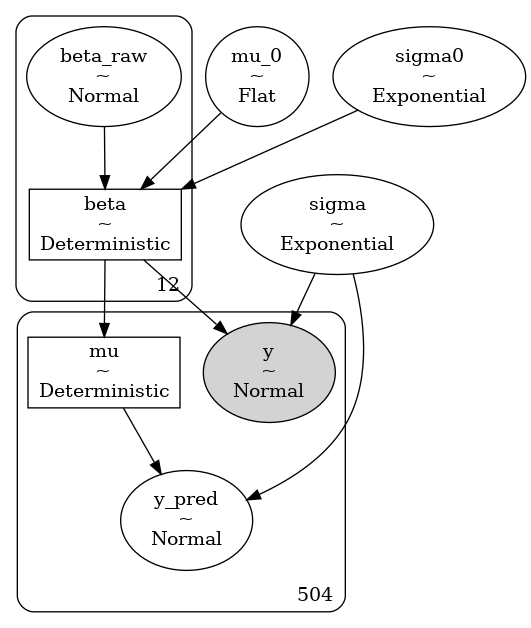

In [24]:
import pymc3 as pm
# PyMC3 Model
with pm.Model() as model:
    # Priors
    beta_raw = pm.Normal('beta_raw', mu=0, sigma=1, shape=discharge_data['K'])
    sigma = pm.Exponential('sigma', lam=0.1)
    mu0 = pm.Flat('mu_0')
    sigma0 = pm.Exponential('sigma0', lam=0.1)
    
    # Transformed parameters
    beta = pm.Deterministic('beta', mu0 + sigma0 * beta_raw)
    
    # Likelihood
    y_like = pm.Normal('y', mu=pm.math.dot(discharge_data['x'], beta), sigma=sigma, observed=discharge_data['y'])
    
    # Generated quantities
    mu = pm.Deterministic('mu', pm.math.dot(discharge_data['x'], beta))
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, shape=discharge_data['N'])

# Create the graphical diagram
graph = pm.model_to_graphviz(model)
graph.format = 'png'
graph.render(filename='spline_centered_fit_model', directory='results')

# Show png image of the graphical diagram
from IPython.display import Image
Image(filename='results/spline_centered_fit_model.png')

In [25]:
fit_discharge = spline_fit.sample(data=discharge_data, seed=25072023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████▌| 00:01 Iteration: 1800 / 2000 [ 90%]  (Sampling)



chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [26]:
fit_discharge.diagnose()

'Processing csv files: /tmp/tmp5q2fl0sl/spline_centered_fit-20230726233849_1.csv, /tmp/tmp5q2fl0sl/spline_centered_fit-20230726233849_2.csv, /tmp/tmp5q2fl0sl/spline_centered_fit-20230726233849_3.csv, /tmp/tmp5q2fl0sl/spline_centered_fit-20230726233849_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

In [27]:
y_pred = fit_discharge.stan_variable('y_pred')
beta_healthy = fit_discharge.stan_variable('beta')
mu = fit_discharge.stan_variable('mu')

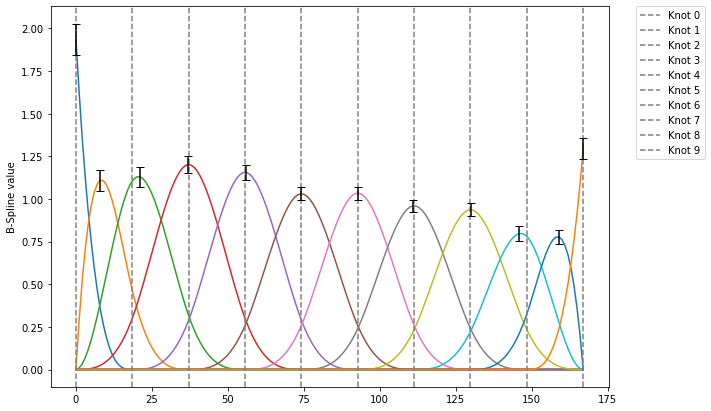

In [28]:
mu_beta = np.mean(beta_healthy, axis=0)
std_beta = np.std(beta_healthy, axis=0)

# Visualization of individual splines
B0 = B[0:M]
spline_components = np.matmul(B0, np.diag(mu_beta))
y_m = 0*mu_beta

for i in range(len(y_m)):
    y_m[i] = max(spline_components[:, i].min(), spline_components[:, i].max(), key=abs)
x_m = np.argmax(np.abs(spline_components), axis=0)

fig, ax = plt.subplots(figsize=(10, 7))
for i in range(knots_number+2):
    ax.plot(time,(spline_components[:, i]), zorder=0)
    if i < knots_number:
        ax.axvline(knots_list[i], color='gray', linestyle='--', label='Knot ' + str(i))
    ax.errorbar(time[x_m[i]], y_m[i], yerr=2*std_beta[i]*y_m[i], color='black', ls='none', capsize=4)
ax.set_ylabel('B-Spline value')
# show labels on the right to the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.savefig('plots/spline_components.png')
plt.show()

/usr/local/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


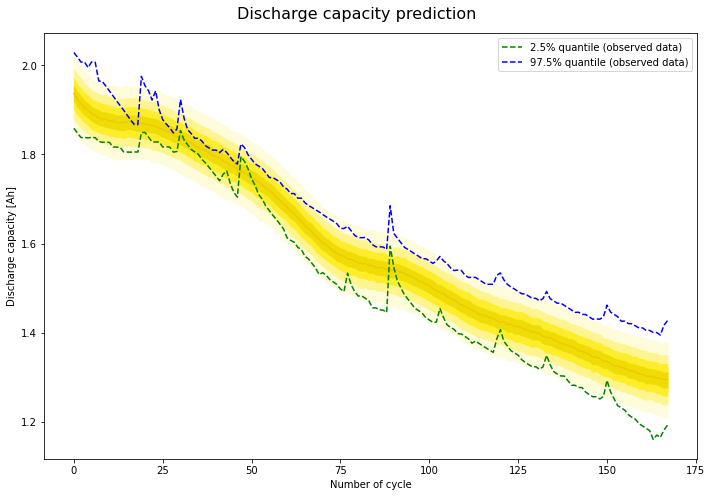

In [29]:
fig, ax_y = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
fig.suptitle('Discharge capacity prediction', fontsize=16)
ax_y = ribbon_plot(np.array(time), y_pred, ax_y)
qs = get_quantiles(df_discharge.iloc[:N*M].pivot(index='cycle_id',columns='battery_id',values='capacity').values.T, [2.5, 50, 97.5])
ax_y.plot(time, qs[0, :], color='green', linestyle='--', label='2.5% quantile (observed data)')
ax_y.plot(time, qs[2, :], color='blue', linestyle='--', label='97.5% quantile (observed data)')
ax_y.set_ylabel('Discharge capacity [Ah]')
ax_y.set_xlabel('Number of cycle')
fig.tight_layout()
plt.legend()
plt.show()
fig.savefig('plots/discharge_capacity_fit.png')

In [30]:
# rated_capacity = 2.0
# # SoC calculation as a ratio of discharge capacity to rated capacity
# fig, ax_y = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
# fig.suptitle('State of Charge prediction', fontsize=16)
# ax_y = ribbon_plot(np.array(time), y_pred/rated_capacity, ax_y)
# qs = get_quantiles(df_discharge.iloc[:N*M].pivot(index='cycle_id',columns='battery_id',values='capacity').values.T/rated_capacity, [2.5, 50, 97.5])
# ax_y.plot(time, qs[0, :], color='green', linestyle='--', label='2.5% quantile (observed data)')
# ax_y.plot(time, qs[2, :], color='blue', linestyle='--', label='97.5% quantile (observed data)')
# ax_y.set_ylabel('State of Charge')
# ax_y.set_xlabel('Number of cycle')
# fig.tight_layout()
# plt.legend()
# plt.show()
# fig.savefig('plots/state_of_charge_fit.png')


In [31]:
# hyperparameters summary for the fit model
hyperparameters_summary = az.summary(fit_discharge, var_names=['mu0', 'sigma0', 'sigma'], round_to=2, kind='stats', hdi_prob=0.95)
print(hyperparameters_summary)
# save hyperparameters summary to csv file
hyperparameters_summary.to_csv('results/hyperparameters_summary.csv')

        mean    sd  hdi_2.5%  hdi_97.5%
mu0     1.59  0.08      1.43       1.76
sigma0  0.28  0.07      0.16       0.41
sigma   0.06  0.00      0.06       0.07


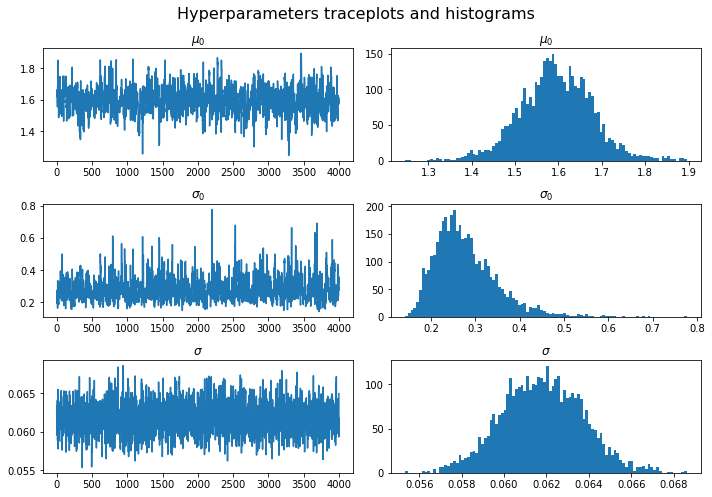

In [32]:
param_names = {'mu0': r'$\mu_0$', 'sigma0': r'$\sigma_0$', 'sigma': r'$\sigma$'}
fig, ax = plt.subplots(3, 2, figsize=(10, 7))
fig.suptitle('Hyperparameters traceplots and histograms', fontsize=16)
for i, param in enumerate(param_names.keys()):
    ax[i, 0].plot(fit_discharge.stan_variable(param))
    ax[i, 0].set_title(param_names[param])
    ax[i, 1].hist(fit_discharge.stan_variable(param), bins=100)
    ax[i, 1].set_title(param_names[param])
fig.tight_layout()
plt.show()
fig.savefig('plots/hyperparameters_traceplots_and_histograms.png')

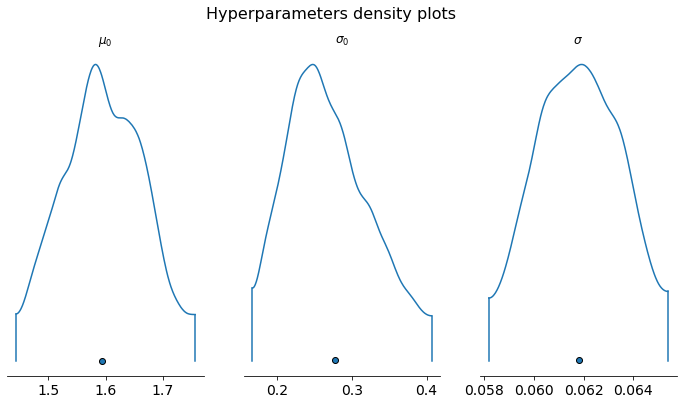

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
fig.suptitle('Hyperparameters density plots', fontsize=16)
ax = az.plot_density(fit_discharge, var_names=[*param_names], ax=ax)
ax[0].set_title(param_names['mu0'])
ax[1].set_title(param_names['sigma0'])
ax[2].set_title(param_names['sigma'])
plt.show()
fig.savefig('plots/hyperparameters_density_plots.png')


## Model 2 - spline fit with regularization strength parameter ($\alpha$)

This model takes into account a parameter $\alpha$, which gives control over the strength of regularization. This is done by supplementing the $\alpha$ parameter to the $\beta$ priors normal distribution. This model takes $\alpha$ as an input.

The new model presents itself like this:
$$\beta \sim Normal(0, \alpha)$$
$$\sigma \sim Exp(0.1)$$
$$y \sim Normal(X * \beta, \sigma)$$

In [34]:
spline_alpha_fit = CmdStanModel(stan_file='model/spline_centered_alpha_fit.stan')

INFO:cmdstanpy:compiling stan file /root/battery-pack-model-and-data/model/spline_centered_alpha_fit.stan to exe file /root/battery-pack-model-and-data/model/spline_centered_alpha_fit


INFO:cmdstanpy:compiled model executable: /root/battery-pack-model-and-data/model/spline_centered_alpha_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/root/battery-pack-model-and-data/model/spline_centered_alpha_fit.hpp /root/battery-pack-model-and-data/model/spline_centered_alpha_fit.stan
Warning in '/root/battery-pack-model-and-data/model/spline_centered_alpha_fit.stan', line 28, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.75.0 -I sta

In [128]:
discharge_alpha_data = {'N': B.shape[0],
                        'K': B.shape[1],
                        'L': M,
                        'x': B,
                        'y': np.array(df_discharge['capacity'].values, dtype=np.float64),
                        'alpha': 0.119}

In [129]:
fit_alpha_discharge = spline_alpha_fit.sample(data=discharge_alpha_data, seed=25072023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [130]:
fit_alpha_discharge.diagnose()

"Processing csv files: /tmp/tmp5q2fl0sl/spline_centered_alpha_fit-20230726234226_1.csv, /tmp/tmp5q2fl0sl/spline_centered_alpha_fit-20230726234226_2.csv, /tmp/tmp5q2fl0sl/spline_centered_alpha_fit-20230726234226_3.csv, /tmp/tmp5q2fl0sl/spline_centered_alpha_fit-20230726234226_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\n248 of 4000 (6.20%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta closer to 1.\nIf this doesn't remove all divergences, try to reparameterize the model.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nThe E-BFMI, 0.00, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.\nIf possible, try to reparameterize the model.\n\nThe following parameters had fewer than 0.001 effective d

In [131]:
y_pred_alpha = fit_alpha_discharge.stan_variable('y_pred')
beta_healthy_alpha = fit_alpha_discharge.stan_variable('beta')
mu_alpha = fit_alpha_discharge.stan_variable('mu')

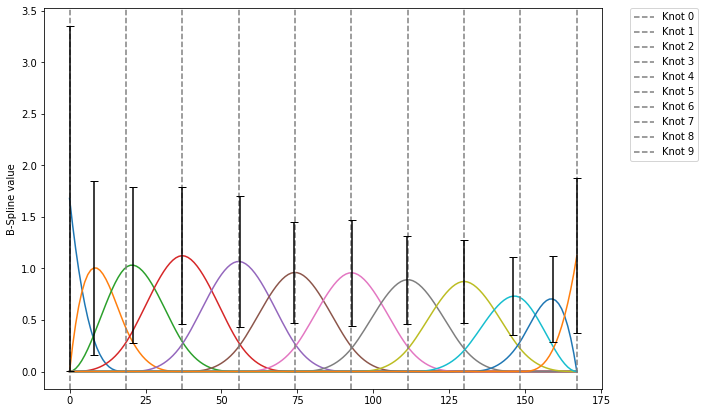

In [132]:
mu_beta = np.mean(beta_healthy_alpha, axis=0)
std_beta = np.std(beta_healthy_alpha, axis=0)

# Visualization of individual splines
B0 = B[0:M]
spline_components = np.matmul(B0, np.diag(mu_beta))
y_m = 0*mu_beta

for i in range(len(y_m)):
    y_m[i] = max(spline_components[:, i].min(), spline_components[:, i].max(), key=abs)
x_m = np.argmax(np.abs(spline_components), axis=0)

fig, ax = plt.subplots(figsize=(10, 7))
for i in range(knots_number+2):
    ax.plot(time,(spline_components[:, i]), zorder=0)
    if i < knots_number:
        ax.axvline(knots_list[i], color='gray', linestyle='--', label='Knot ' + str(i))
    ax.errorbar(time[x_m[i]], y_m[i], yerr=2*std_beta[i]*y_m[i], color='black', ls='none', capsize=4)
ax.set_ylabel('B-Spline value')
# show labels on the right to the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.savefig('plots/spline_components_alpha_fit.png')
plt.show()

/usr/local/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


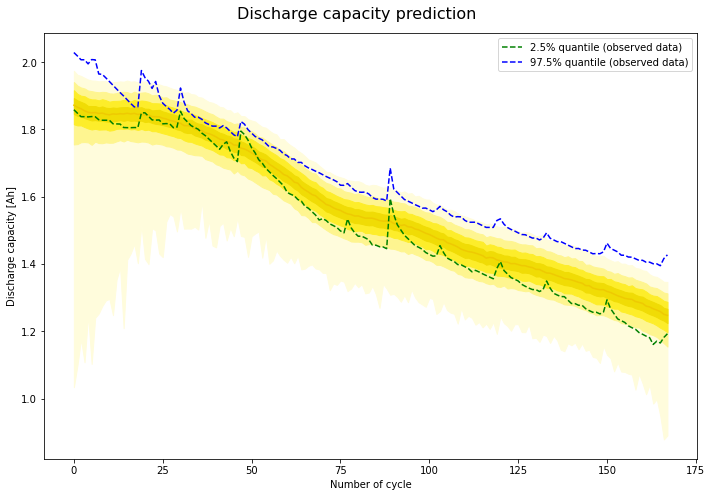

In [133]:
fig, ax_y = plt.subplots(1, 1, figsize=(10, 7), sharex=True)
fig.suptitle('Discharge capacity prediction', fontsize=16)
ax_y = ribbon_plot(np.array(time), y_pred_alpha, ax_y)
qs = get_quantiles(df_discharge.iloc[:N*M].pivot(index='cycle_id',columns='battery_id',values='capacity').values.T, [2.5, 50, 97.5])
ax_y.plot(time, qs[0, :], color='green', linestyle='--', label='2.5% quantile (observed data)')
ax_y.plot(time, qs[2, :], color='blue', linestyle='--', label='97.5% quantile (observed data)')
ax_y.set_ylabel('Discharge capacity [Ah]')
ax_y.set_xlabel('Number of cycle')
fig.tight_layout()
plt.legend()
plt.show()
fig.savefig('plots/discharge_capacity_alpha_fit.png')

In [134]:
# hyperparameters summary for the fit model
hyperparameters_summary = az.summary(fit_discharge, var_names=['mu0', 'sigma0', 'sigma'], round_to=2, kind='stats', hdi_prob=0.95)
print(hyperparameters_summary)
# save hyperparameters summary to csv file
hyperparameters_summary.to_csv('results/hyperparameters_summary.csv')

        mean    sd  hdi_2.5%  hdi_97.5%
mu0     1.59  0.08      1.43       1.76
sigma0  0.28  0.07      0.16       0.41
sigma   0.06  0.00      0.06       0.07


In [135]:
param_names = {'mu0': r'$\mu_0$', 'sigma0': r'$\sigma_0$', 'sigma': r'$\sigma$'}

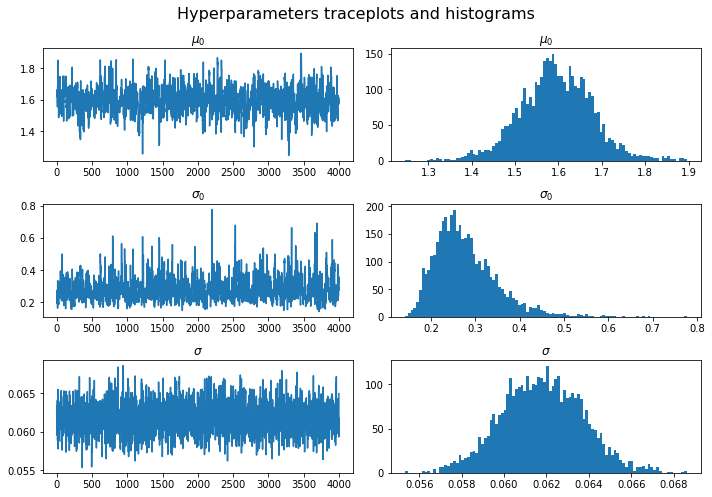

In [136]:
fig, ax = plt.subplots(3, 2, figsize=(10, 7))
fig.suptitle('Hyperparameters traceplots and histograms', fontsize=16)
for i, param in enumerate(param_names.keys()):
    ax[i, 0].plot(fit_discharge.stan_variable(param))
    ax[i, 0].set_title(param_names[param])
    ax[i, 1].hist(fit_discharge.stan_variable(param), bins=100)
    ax[i, 1].set_title(param_names[param])
fig.tight_layout()
plt.show()

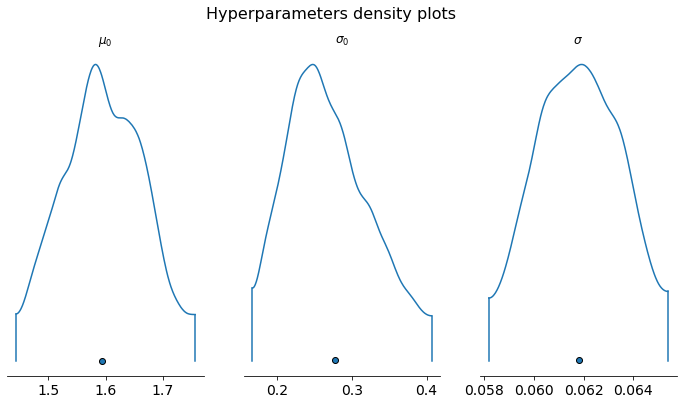

In [137]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
fig.suptitle('Hyperparameters density plots', fontsize=16)
ax = az.plot_density(fit_discharge, var_names=[*param_names], ax=ax)
ax[0].set_title(param_names['mu0'])
ax[1].set_title(param_names['sigma0'])
ax[2].set_title(param_names['sigma'])
plt.show()

# Model comparison

We can use the model with additional hyperparameter $\alpha$ to get the first model (without $\alpha$). To do that, we will set $\alpha$ to $1$, because that was the fixed value for the first model.

In [138]:
if_data_1 = az.from_cmdstanpy(fit_discharge, log_likelihood='log_likelihood')
if_data_2 = az.from_cmdstanpy(fit_alpha_discharge, log_likelihood='log_likelihood')

In [139]:
models = {'model_spline' : if_data_1, 'model_spline_alpha' : if_data_2}

In [140]:
models_loo = az.compare(compare_dict=models, ic='loo')
models_waic = az.compare(compare_dict=models, ic='waic')

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


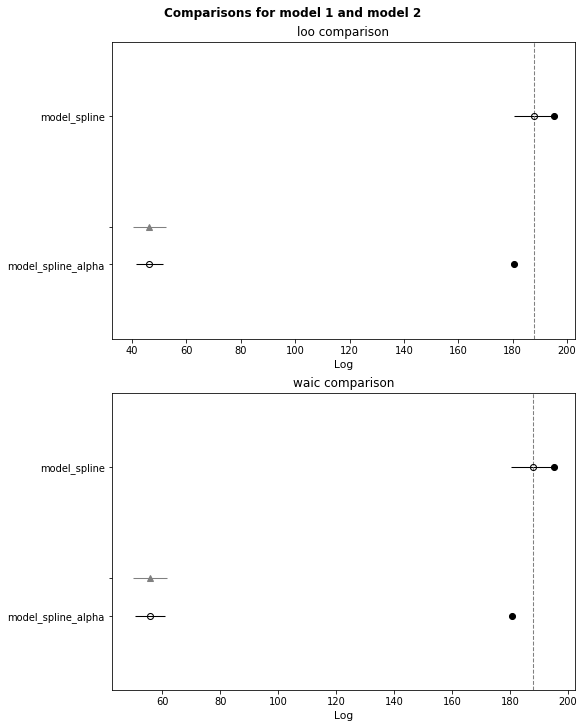

In [141]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10), constrained_layout=True)
az.plot_compare(models_loo, ax=ax[0])
az.plot_compare(models_waic, ax=ax[1])
ax[0].set_title('loo comparison')
ax[1].set_title('waic comparison')
plt.suptitle("Comparisons for model 1 and model 2", fontweight='bold')
plt.show()

## Comments on the comparison results

In the case of LOO, the model including the alpha parameter has lower ELPD by far. The in-sample ELPD point seems way closer to the model without alpha.

# Final comments and conclusions

The models are similar in the way they work. However, the alpha parameter, _if carefully chosen_, allows for a better fit.

Overall, this approach seems to have probable results. It does need significant refinements to be useful though.